In [7]:
from huggingface_hub import notebook_login


In [8]:
notebook_login()


ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [9]:
from datasets import load_dataset


In [27]:
dataset = load_dataset("imagefolder", data_dir="../experimental/imgs/", split='train', drop_labels=False)


Resolving data files: 100%|██████████| 436/436 [00:00<00:00, 467343.87it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 436 examples [00:00, 17830.35 examples/s]


In [28]:
dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 436
})

In [29]:
split_dataset = dataset.train_test_split(test_size=0.1)


In [13]:
from transformers import SwinForImageClassification, SwinConfig, TrainingArguments, Trainer


In [14]:
from datasets import load_metric

metric = load_metric("accuracy")


/var/folders/tf/xcqcrf2n4kqgmmsn4w_t22b80000gn/T/ipykernel_63355/99795553.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [21]:
example = split_dataset["train"][10]
example


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=70x60>}

In [20]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
feature_extractor


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size["width"], feature_extractor.size["height"])),
            CenterCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


In [30]:
labels = split_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]


'アラブルタケ'

In [31]:
train_ds = split_dataset['train']
val_ds = split_dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [32]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([152, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([152]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model_name = "pokemon_image_classifier"
batch_size = 16

args = TrainingArguments(
    model_name,
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


In [34]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


In [35]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [36]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


In [37]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


/Users/yusuke-fukasawa/Library/Caches/pypoetry/virtualenvs/poke-battle-logger-xYV7PrtE-py3.10/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                               
  5%|▌         | 6/120 [01:47<31:45, 16.71s/it]

{'eval_loss': 4.951968669891357, 'eval_accuracy': 0.022727272727272728, 'eval_runtime': 4.527, 'eval_samples_per_second': 9.72, 'eval_steps_per_second': 0.663, 'epoch': 0.96}


  8%|▊         | 10/120 [02:52<31:35, 17.23s/it]

{'loss': 4.9945, 'learning_rate': 4.166666666666667e-05, 'epoch': 1.6}


                                                
 10%|█         | 12/120 [03:36<30:30, 16.95s/it]

{'eval_loss': 4.551794052124023, 'eval_accuracy': 0.13636363636363635, 'eval_runtime': 4.504, 'eval_samples_per_second': 9.769, 'eval_steps_per_second': 0.666, 'epoch': 1.92}


                                                
 15%|█▌        | 18/120 [05:24<28:33, 16.79s/it]

{'eval_loss': 3.9259047508239746, 'eval_accuracy': 0.29545454545454547, 'eval_runtime': 4.7184, 'eval_samples_per_second': 9.325, 'eval_steps_per_second': 0.636, 'epoch': 2.88}


 17%|█▋        | 20/120 [05:46<29:24, 17.65s/it]

{'loss': 4.2877, 'learning_rate': 4.62962962962963e-05, 'epoch': 3.2}


                                                
 21%|██        | 25/120 [07:11<25:16, 15.96s/it]

{'eval_loss': 3.0556862354278564, 'eval_accuracy': 0.4090909090909091, 'eval_runtime': 4.6388, 'eval_samples_per_second': 9.485, 'eval_steps_per_second': 0.647, 'epoch': 4.0}


 25%|██▌       | 30/120 [08:34<25:12, 16.81s/it]

{'loss': 2.9252, 'learning_rate': 4.166666666666667e-05, 'epoch': 4.8}


                                                
 26%|██▌       | 31/120 [08:57<24:37, 16.60s/it]

{'eval_loss': 2.430053949356079, 'eval_accuracy': 0.5681818181818182, 'eval_runtime': 4.5072, 'eval_samples_per_second': 9.762, 'eval_steps_per_second': 0.666, 'epoch': 4.96}


                                                
 31%|███       | 37/120 [10:42<22:44, 16.44s/it]

{'eval_loss': 1.9038513898849487, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 4.5083, 'eval_samples_per_second': 9.76, 'eval_steps_per_second': 0.665, 'epoch': 5.92}


 33%|███▎      | 40/120 [11:25<22:37, 16.97s/it]

{'loss': 1.8728, 'learning_rate': 3.7037037037037037e-05, 'epoch': 6.4}


                                                
 36%|███▌      | 43/120 [12:28<21:03, 16.41s/it]

{'eval_loss': 1.5274890661239624, 'eval_accuracy': 0.7954545454545454, 'eval_runtime': 4.491, 'eval_samples_per_second': 9.797, 'eval_steps_per_second': 0.668, 'epoch': 6.88}


 42%|████▏     | 50/120 [14:09<18:26, 15.81s/it]

{'loss': 1.2156, 'learning_rate': 3.240740740740741e-05, 'epoch': 8.0}


                                                
 42%|████▏     | 50/120 [14:14<18:26, 15.81s/it]

{'eval_loss': 1.2410820722579956, 'eval_accuracy': 0.8409090909090909, 'eval_runtime': 4.6489, 'eval_samples_per_second': 9.465, 'eval_steps_per_second': 0.645, 'epoch': 8.0}


                                                
 47%|████▋     | 56/120 [16:00<17:35, 16.49s/it]

{'eval_loss': 1.050150752067566, 'eval_accuracy': 0.8636363636363636, 'eval_runtime': 4.4903, 'eval_samples_per_second': 9.799, 'eval_steps_per_second': 0.668, 'epoch': 8.96}


 50%|█████     | 60/120 [17:02<16:41, 16.70s/it]

{'loss': 0.7054, 'learning_rate': 2.777777777777778e-05, 'epoch': 9.6}


                                                
 52%|█████▏    | 62/120 [17:45<15:54, 16.46s/it]

{'eval_loss': 0.9213514924049377, 'eval_accuracy': 0.9090909090909091, 'eval_runtime': 4.4575, 'eval_samples_per_second': 9.871, 'eval_steps_per_second': 0.673, 'epoch': 9.92}


                                                
 57%|█████▋    | 68/120 [19:32<14:17, 16.49s/it]

{'eval_loss': 0.8220176100730896, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.4549, 'eval_samples_per_second': 9.877, 'eval_steps_per_second': 0.673, 'epoch': 10.88}


 58%|█████▊    | 70/120 [19:54<14:21, 17.23s/it]

{'loss': 0.4799, 'learning_rate': 2.314814814814815e-05, 'epoch': 11.2}


                                                
 62%|██████▎   | 75/120 [21:17<11:50, 15.78s/it]

{'eval_loss': 0.7392436861991882, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.6533, 'eval_samples_per_second': 9.456, 'eval_steps_per_second': 0.645, 'epoch': 12.0}


 67%|██████▋   | 80/120 [22:41<11:05, 16.64s/it]

{'loss': 0.371, 'learning_rate': 1.8518518518518518e-05, 'epoch': 12.8}


                                                
 68%|██████▊   | 81/120 [23:03<10:42, 16.48s/it]

{'eval_loss': 0.6964021325111389, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.5039, 'eval_samples_per_second': 9.769, 'eval_steps_per_second': 0.666, 'epoch': 12.96}


                                                
 72%|███████▎  | 87/120 [24:49<09:04, 16.51s/it]

{'eval_loss': 0.6846140623092651, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.3748, 'eval_samples_per_second': 10.058, 'eval_steps_per_second': 0.686, 'epoch': 13.92}


 75%|███████▌  | 90/120 [25:32<08:29, 17.00s/it]

{'loss': 0.4087, 'learning_rate': 1.388888888888889e-05, 'epoch': 14.4}


                                                
 78%|███████▊  | 93/120 [26:36<07:26, 16.52s/it]

{'eval_loss': 0.6801443696022034, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.5678, 'eval_samples_per_second': 9.633, 'eval_steps_per_second': 0.657, 'epoch': 14.88}


 83%|████████▎ | 100/120 [28:17<05:17, 15.85s/it]

{'loss': 0.3756, 'learning_rate': 9.259259259259259e-06, 'epoch': 16.0}


                                                 
 83%|████████▎ | 100/120 [28:22<05:17, 15.85s/it]

{'eval_loss': 0.6756999492645264, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.9748, 'eval_samples_per_second': 8.845, 'eval_steps_per_second': 0.603, 'epoch': 16.0}


                                                 
 88%|████████▊ | 106/120 [30:07<03:51, 16.52s/it]

{'eval_loss': 0.6735906600952148, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.5373, 'eval_samples_per_second': 9.697, 'eval_steps_per_second': 0.661, 'epoch': 16.96}


 92%|█████████▏| 110/120 [31:10<02:47, 16.79s/it]

{'loss': 0.3268, 'learning_rate': 4.6296296296296296e-06, 'epoch': 17.6}


                                                 
 93%|█████████▎| 112/120 [31:53<02:11, 16.44s/it]

{'eval_loss': 0.6670541763305664, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.5011, 'eval_samples_per_second': 9.775, 'eval_steps_per_second': 0.667, 'epoch': 17.92}


                                                 
 98%|█████████▊| 118/120 [33:39<00:32, 16.47s/it]

{'eval_loss': 0.6629387140274048, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.5495, 'eval_samples_per_second': 9.671, 'eval_steps_per_second': 0.659, 'epoch': 18.88}


100%|██████████| 120/120 [34:02<00:00, 17.38s/it]

{'loss': 0.3425, 'learning_rate': 0.0, 'epoch': 19.2}


                                                 
100%|██████████| 120/120 [34:07<00:00, 17.38s/it]

{'eval_loss': 0.662424623966217, 'eval_accuracy': 0.9318181818181818, 'eval_runtime': 4.7156, 'eval_samples_per_second': 9.331, 'eval_steps_per_second': 0.636, 'epoch': 19.2}


100%|██████████| 120/120 [34:09<00:00, 17.08s/it]


{'train_runtime': 2049.1828, 'train_samples_per_second': 3.826, 'train_steps_per_second': 0.059, 'train_loss': 1.5254860500494638, 'epoch': 19.2}
***** train metrics *****
  epoch                    =       19.2
  train_loss               =     1.5255
  train_runtime            = 0:34:09.18
  train_samples_per_second =      3.826
  train_steps_per_second   =      0.059


In [38]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]

***** eval metrics *****
  epoch                   =       19.2
  eval_accuracy           =     0.9318
  eval_loss               =      0.822
  eval_runtime            = 0:00:04.84
  eval_samples_per_second =      9.075
  eval_steps_per_second   =      0.619


In [39]:
# 推論テスト
import cv2
from PIL import Image
from transformers import pipeline

classifier_pipe = pipeline(task="image-classification", model=trainer.model, feature_extractor=feature_extractor)
pokemon_image = cv2.imread("../template_images/user_labeled_pokemon_templates/ヒスイヌメルゴン/20230719104544.png")
pokemon_image2 = cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB)
pokemon_image3 = Image.fromarray(pokemon_image2)
classifier_pipe(pokemon_image3)


[{'score': 0.9919895529747009, 'label': 'ヒスイヌメルゴン'},
 {'score': 0.0007619492243975401, 'label': 'ヒスイウォーグル'},
 {'score': 0.0003471301752142608, 'label': 'ドヒドイデ'},
 {'score': 0.00028295285301283, 'label': 'ブリムオン'},
 {'score': 0.00027114013209939003, 'label': 'デカヌチャン'}]

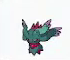

In [40]:
val_ds[0]['image']


In [41]:
classifier_pipe(val_ds[0]['image'])


[{'score': 0.9889816045761108, 'label': 'ハバタクカミ'},
 {'score': 0.0007592097390443087, 'label': 'サザンドラ'},
 {'score': 0.0005425364361144602, 'label': 'ゴチルゼル'},
 {'score': 0.00048544767196290195, 'label': 'キノガッサ'},
 {'score': 0.00046275006025098264, 'label': 'ガブリアス'}]

In [42]:
for idx, _val in enumerate(val_ds):
    predict = classifier_pipe(_val['image'])
    _label = id2label[_val["label"]]
    print(idx, predict[0], _label)


0 {'score': 0.9889816045761108, 'label': 'ハバタクカミ'} ハバタクカミ
1 {'score': 0.35072195529937744, 'label': 'カラミンゴ'} カラミンゴ
2 {'score': 0.9937918782234192, 'label': 'ハッサム'} ハッサム
3 {'score': 0.8469821810722351, 'label': 'ミミズズ'} ミミズズ
4 {'score': 0.3709721267223358, 'label': 'ドヒドイデ'} ドヒドイデ
5 {'score': 0.9871374368667603, 'label': 'ミミズズ'} ミミズズ
6 {'score': 0.9710473418235779, 'label': '炎オーガポン'} 炎オーガポン
7 {'score': 0.2450817972421646, 'label': 'ゾロアーク'} イダイトウ・オス
8 {'score': 0.08239905536174774, 'label': 'ウインディ'} ペルシアン
9 {'score': 0.9908022880554199, 'label': 'コノヨザル'} コノヨザル
10 {'score': 0.9832325577735901, 'label': 'サザンドラ'} サザンドラ
11 {'score': 0.9896446466445923, 'label': 'ヌメルゴン'} ヌメルゴン
12 {'score': 0.18802648782730103, 'label': 'オーロンゲ'} オーロンゲ
13 {'score': 0.9483135342597961, 'label': 'ヒスイドレディア'} ヒスイドレディア
14 {'score': 0.9495557546615601, 'label': 'バサギリ'} バサギリ
15 {'score': 0.43565312027931213, 'label': 'チヲハウハネ'} チヲハウハネ
16 {'score': 0.9257558584213257, 'label': 'ヒスイウォーグル'} ヒスイウォーグル
17 {'score': 0.995822548

In [43]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="pokemon_image_classifier/config.json",
    path_in_repo="config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F30/config.json'

In [45]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/pytorch_model.bin",
    path_in_repo="pytorch_model.bin",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F31/pytorch_model.bin'

In [26]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)


'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F29/preprocessor_config.json'